# ISPR Home Work 2

### Student: Moroni Luca
### Mat: 635966

## Assignment: 3

## Importing used libraries

In [ ]:
!pip install idx2numpy

import idx2numpy
import gzip
import numpy as np
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.utils import gen_batches
from tqdm import tqdm

## Load dataset from ubyte files

This method take the original files given by the trace of the midterm and their original division in train-test split, need to upload the compressed files.

In [ ]:
# Images
with gzip.open("train-images-idx3-ubyte.gz") as f:
  X_train = idx2numpy.convert_from_file(f)

with gzip.open("t10k-images-idx3-ubyte.gz") as f:
  X_test = idx2numpy.convert_from_file(f)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1]*X_train.shape[2])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1]*X_test.shape[2])

# Labels
with gzip.open("train-labels-idx1-ubyte.gz") as f:
  y_train = idx2numpy.convert_from_file(f)

with gzip.open("t10k-labels-idx1-ubyte.gz") as f:
  y_test = idx2numpy.convert_from_file(f)

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

In [ ]:
# shuffle the data
train_permutation = np.random.permutation(X_train.shape[0])
test_permutation = np.random.permutation(X_test.shape[0])

X_train = X_train[train_permutation]
y_train = y_train[train_permutation]

X_test = X_test[test_permutation]
y_test = y_test[test_permutation]

## Load dataset from sklearn

This method permit to don't upload the files each time

In [ ]:
# Load data from https://www.openml.org/d/554
X, y = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=10000, random_state=42
)

In [ ]:
print("shape of X and y in train: ", X_train.shape, y_train.shape)
print("shape of X and y in test: ", X_test.shape, y_test.shape)

shape of X and y in train:  (60000, 784) (60000,)
shape of X and y in test:  (10000, 784) (10000,)


### Show some images

In [ ]:
def show_table_images(data, text, dim = 10):
  plt.figure(figsize=(dim, dim))
  for i, comp in enumerate(data):
      plt.subplot(dim, dim, i + 1)
      plt.imshow(comp.reshape((28, 28)), cmap=plt.cm.gray_r, interpolation="nearest")
      plt.xticks(())
      plt.yticks(())
  plt.suptitle(text, fontsize=16)
  plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.23)

  plt.show()

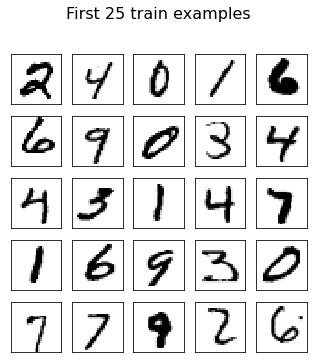

In [ ]:
show_table_images(X_train[:25], "First 25 train examples", 5)

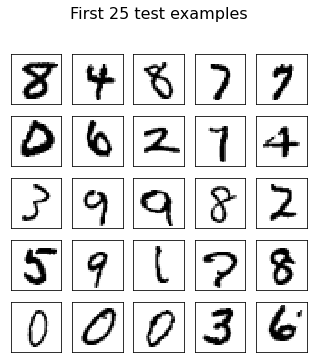

In [ ]:
show_table_images(X_test[:25], "First 25 test examples", 5)

## Preprocessing

Preprocess the data using MinMaxScaler from sklearn to have input values in the range $[0-1]$.

In [ ]:
min_max = MinMaxScaler()
min_max.fit(X_train)
X_train = min_max.transform(X_train)
X_test = min_max.transform(X_test)

## Sklearn classifier over original data

Apply a linear classifier (LogisticRegression from sklearn) directly over the mnist data, the accuracy obtained by this model trained over the original data will be compared to another linear model trainied over the preprocessed data passed throught a RBM model.

In [ ]:
linear_classifier = LogisticRegression(max_iter=500)
linear_classifier.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression(max_iter=500)

In [ ]:
y_train_pred = linear_classifier.predict(X_train)
y_test_pred = linear_classifier.predict(X_test)

In [ ]:
print(f"Accuracy over training set {metrics.accuracy_score(y_train, y_train_pred, normalize=True)}")
print(f"Accuracy over test set  {metrics.accuracy_score(y_test, y_test_pred, normalize=True)}")

Accuracy over training set 0.9394166666666667
Accuracy over test set  0.9207


## Restricted Boltzmann Machine

In the following cell it's present the RBM model implementation.

The model expect to take in input data with values in $[0-1]$, the implementations choices follows the best practices explained in http://www.cs.toronto.edu/~hinton/absps/guideTR.pdf and the guidelines in the course's slide.

In [ ]:
class RBM():
  def __init__(self, input_dim, hidden_dim, std_w_init = 0.01):
    self.input_dim = input_dim
    self.hidden_dim = hidden_dim
    self.W = std_w_init*np.random.randn(input_dim, hidden_dim)
    self.b_h = std_w_init*np.random.randn(hidden_dim)
    self.b_v = std_w_init*np.random.randn(input_dim)

  def _sample(self, X):
    """
    Given X as a tensor of probabilities, returns a binary tensor of the same dimension
    of X, with P(X[i, ..., j] = 1) = X[i, ..., j]

    Args:
        X (np.array): A numpy array with values in [0-1].

    Returns:
        np.array: A binary numpy array.
    """

    return 1*(X > np.random.uniform(size=X.shape))

  def training(self, X_train, epochs = 100, batch_size = 64, learning_rate = 1):
    """
    Training function, train the parameters of the RBM model over the X_train dataset.
    Applying Stochastic Gradient Ascent

    Args:
        X_train (np.array): The training dataset, a numpy array with values in [0-1].
        epochs (int): train epochs, the number of iterations of the training over the entire dataset.
        batch_size (int): dimension of the single subset of the training dataset used to do an update of the parameters.
        learning_rate (int): the learning rate of the stochastic gradient ascent.
    """

    gen_batches(X_train.shape[0], batch_size)
    for epoch in range(epochs):
      epoch_reconstruction_error = 0
      batches = list(gen_batches(X_train.shape[0], batch_size))
      for batch_slice in tqdm(batches):
        batch_slice_start = batch_slice.start
        batch_slice_stop = batch_slice.stop
        batch = X_train[batch_slice_start:batch_slice_stop]
        epoch_reconstruction_error += self._contrastive_divergence(batch, learning_rate)
      epoch_reconstruction_error /= len(batches)
      print(f"Epoch {epoch + 1}: reconstruction error = {epoch_reconstruction_error}")

  def _contrastive_divergence(self, X, learning_rate = 1):
    """
    A single step of Contrastive Divergence algorithm, update the parameters of the models
    with a rougly approximation of the gradient of the log-likelyhood function of the model.

    Args:
        X (np.array): The Dataset used to compute the contrastive divergence step, instances with values in [0-1].
        learning_rate (int): the learning rate of the stochastic gradient ascent.
    Return:
        (float): reconstruction error over the dataset used to learn.
    """

    N = X.shape[0]

    X_sample = self._sample(X)

    # --- WAKE ---

    hidden_0_p = np.ones((N, self.hidden_dim))
    hidden_0_p = hidden_0_p/(hidden_0_p + np.exp(-(X_sample@self.W + self.b_h)))

    # the first update of hidden unit has to be binary.
    
    hidden_0_s = self._sample(hidden_0_p)

    # to compute the statistics for learning its common to use the probabilities
    # for the hidden units, allow us to faster learning having less sampling noise.
    wake = X_sample.T @ hidden_0_p

    # --- DREAM ---

    visible_1_p = np.ones((N, self.input_dim))
    visible_1_p = visible_1_p/(visible_1_p + np.exp(-(hidden_0_s@self.W.T + self.b_v)))

    # sample visible_1 to compute the reconstruction error
    visible_1_s = self._sample(visible_1_p)

    hidden_1_p = np.ones((N, self.hidden_dim))
    hidden_1_p = hidden_1_p/(hidden_1_p + np.exp(-(visible_1_s@self.W + self.b_h)))

    # to compute the statistics for learning its common to use the probabilities
    # for the hidden units, allow us to faster learning having less sampling noise.
    dream = visible_1_s.T @ hidden_1_p

    # --- UPDATE ---

    reconstruction_error = np.sum((X_sample - visible_1_s)**2)/N

    deltaW = (wake - dream)/N
    deltaBv = (np.sum(X_sample - visible_1_s, axis=0))/N
    deltaBh = (np.sum(hidden_0_p - hidden_1_p, axis=0))/N

    # update...
    self.W += deltaW*learning_rate
    self.b_v += deltaBv*learning_rate
    self.b_h += deltaBh*learning_rate

    return reconstruction_error

  def reconstruct(self, X):
    """
    Reconstruct the input instances X passing throught the RBM hidden state.

    Args:
        X (np.array): A numpy array with values in [0-1].
    Returns:
        (np.array): matrix of the reconstructed data.
    """

    N = X.shape[0]

    X_sample = self._sample(X)

    hidden_0_p = np.ones((N, self.hidden_dim))
    hidden_0_p = hidden_0_p/(hidden_0_p + np.exp(-(X_sample@self.W + self.b_h)))

    hidden_0_s = self._sample(hidden_0_p)
    
    visible_1_p = np.ones((N, self.input_dim))
    visible_1_p = visible_1_p/(visible_1_p + np.exp(-(hidden_0_s@self.W.T + self.b_v)))

    return visible_1_p
  
  def inference(self, X):
    """
    Compute the probabilites of the hidden state given input instances.

    Args:
        X (np.array): A numpy array with values in [0-1].
    Returns:
        (np.array); matrix of the reconstructed data.
    """

    N = X.shape[0]

    X_sample = self._sample(X)

    hidden_0_p = np.ones((N, self.hidden_dim))
    hidden_0_p = hidden_0_p/(hidden_0_p + np.exp(-(X_sample@self.W + self.b_h)))
    return hidden_0_p

## Preprocess dataset with RBM

First of all I train the RBM model over the training dataset, passing to the model the images with the entries in $[0-1]$.
The training parameters are been choosen after a soft screening phase, were i have done some runs with other parameters.

In [ ]:
rbm = RBM(28*28, 144)
rbm.training(X_train, epochs = 50, batch_size = 100, learning_rate = 0.2)

100%|██████████| 600/600 [00:10<00:00, 56.65it/s]


Epoch 1: reconstruction error = 81.71389999999987


100%|██████████| 600/600 [00:10<00:00, 55.26it/s]


Epoch 2: reconstruction error = 59.40148333333336


100%|██████████| 600/600 [00:10<00:00, 54.78it/s]


Epoch 3: reconstruction error = 54.38641666666668


100%|██████████| 600/600 [00:10<00:00, 54.61it/s]


Epoch 4: reconstruction error = 51.46906666666664


100%|██████████| 600/600 [00:10<00:00, 55.24it/s]


Epoch 5: reconstruction error = 49.528216666666644


100%|██████████| 600/600 [00:10<00:00, 55.76it/s]


Epoch 6: reconstruction error = 48.09265000000003


100%|██████████| 600/600 [00:10<00:00, 55.35it/s]


Epoch 7: reconstruction error = 47.05469999999999


100%|██████████| 600/600 [00:10<00:00, 56.52it/s]


Epoch 8: reconstruction error = 46.27506666666664


100%|██████████| 600/600 [00:10<00:00, 55.47it/s]


Epoch 9: reconstruction error = 45.72680000000005


100%|██████████| 600/600 [00:10<00:00, 56.36it/s]


Epoch 10: reconstruction error = 45.17556666666665


100%|██████████| 600/600 [00:10<00:00, 56.73it/s]


Epoch 11: reconstruction error = 44.77251666666673


100%|██████████| 600/600 [00:10<00:00, 56.58it/s]


Epoch 12: reconstruction error = 44.43375


100%|██████████| 600/600 [00:10<00:00, 57.60it/s]


Epoch 13: reconstruction error = 44.14556666666663


100%|██████████| 600/600 [00:10<00:00, 56.44it/s]


Epoch 14: reconstruction error = 43.86675000000005


100%|██████████| 600/600 [00:10<00:00, 55.88it/s]


Epoch 15: reconstruction error = 43.6512833333333


100%|██████████| 600/600 [00:10<00:00, 57.96it/s]


Epoch 16: reconstruction error = 43.46511666666664


100%|██████████| 600/600 [00:10<00:00, 57.34it/s]


Epoch 17: reconstruction error = 43.338316666666664


100%|██████████| 600/600 [00:10<00:00, 57.10it/s]


Epoch 18: reconstruction error = 43.20405000000007


100%|██████████| 600/600 [00:10<00:00, 56.74it/s]


Epoch 19: reconstruction error = 43.068516666666646


100%|██████████| 600/600 [00:10<00:00, 56.91it/s]


Epoch 20: reconstruction error = 42.903116666666705


100%|██████████| 600/600 [00:10<00:00, 58.33it/s]


Epoch 21: reconstruction error = 42.8304666666667


100%|██████████| 600/600 [00:10<00:00, 58.41it/s]


Epoch 22: reconstruction error = 42.731166666666695


100%|██████████| 600/600 [00:10<00:00, 57.61it/s]


Epoch 23: reconstruction error = 42.558550000000004


100%|██████████| 600/600 [00:10<00:00, 56.93it/s]


Epoch 24: reconstruction error = 42.510633333333274


100%|██████████| 600/600 [00:10<00:00, 56.90it/s]


Epoch 25: reconstruction error = 42.42756666666663


100%|██████████| 600/600 [00:10<00:00, 57.64it/s]


Epoch 26: reconstruction error = 42.39316666666667


100%|██████████| 600/600 [00:10<00:00, 58.26it/s]


Epoch 27: reconstruction error = 42.30616666666664


100%|██████████| 600/600 [00:10<00:00, 56.70it/s]


Epoch 28: reconstruction error = 42.189233333333355


100%|██████████| 600/600 [00:10<00:00, 56.99it/s]


Epoch 29: reconstruction error = 42.154500000000034


100%|██████████| 600/600 [00:10<00:00, 57.65it/s]


Epoch 30: reconstruction error = 42.05111666666666


100%|██████████| 600/600 [00:10<00:00, 57.39it/s]


Epoch 31: reconstruction error = 42.008999999999965


100%|██████████| 600/600 [00:10<00:00, 57.27it/s]


Epoch 32: reconstruction error = 41.97588333333327


100%|██████████| 600/600 [00:10<00:00, 56.70it/s]


Epoch 33: reconstruction error = 41.90871666666666


100%|██████████| 600/600 [00:10<00:00, 57.67it/s]


Epoch 34: reconstruction error = 41.8957166666667


100%|██████████| 600/600 [00:10<00:00, 57.11it/s]


Epoch 35: reconstruction error = 41.79015000000003


100%|██████████| 600/600 [00:10<00:00, 57.19it/s]


Epoch 36: reconstruction error = 41.78674999999997


100%|██████████| 600/600 [00:10<00:00, 55.42it/s]


Epoch 37: reconstruction error = 41.71164999999998


100%|██████████| 600/600 [00:10<00:00, 55.67it/s]


Epoch 38: reconstruction error = 41.689099999999975


100%|██████████| 600/600 [00:10<00:00, 56.13it/s]


Epoch 39: reconstruction error = 41.64514999999999


100%|██████████| 600/600 [00:10<00:00, 57.00it/s]


Epoch 40: reconstruction error = 41.583550000000045


100%|██████████| 600/600 [00:10<00:00, 57.41it/s]


Epoch 41: reconstruction error = 41.60854999999994


100%|██████████| 600/600 [00:10<00:00, 56.36it/s]


Epoch 42: reconstruction error = 41.51696666666668


100%|██████████| 600/600 [00:10<00:00, 56.28it/s]


Epoch 43: reconstruction error = 41.468366666666675


100%|██████████| 600/600 [00:10<00:00, 56.92it/s]


Epoch 44: reconstruction error = 41.47970000000001


100%|██████████| 600/600 [00:10<00:00, 56.43it/s]


Epoch 45: reconstruction error = 41.47623333333334


100%|██████████| 600/600 [00:10<00:00, 56.97it/s]


Epoch 46: reconstruction error = 41.40731666666665


100%|██████████| 600/600 [00:10<00:00, 57.53it/s]


Epoch 47: reconstruction error = 41.388733333333334


100%|██████████| 600/600 [00:10<00:00, 57.02it/s]


Epoch 48: reconstruction error = 41.3580166666667


100%|██████████| 600/600 [00:10<00:00, 57.23it/s]


Epoch 49: reconstruction error = 41.33480000000003


100%|██████████| 600/600 [00:10<00:00, 57.47it/s]

Epoch 50: reconstruction error = 41.26789999999999


Plotting the columns of the learned matrix of the RBM, the components learned during the training phase.

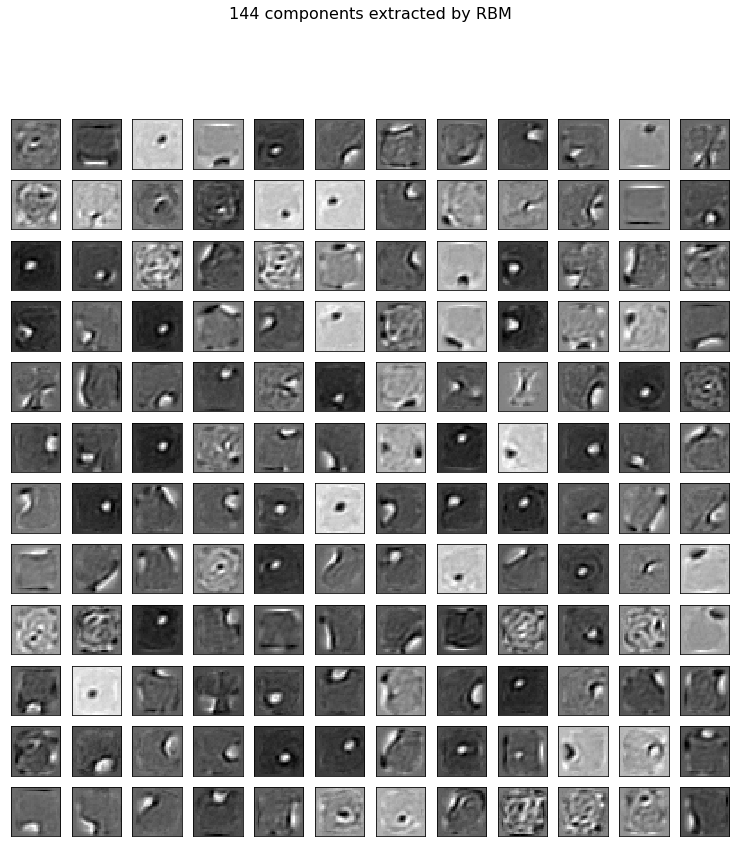

In [ ]:
show_table_images(rbm.W.T, "144 components extracted by RBM", 12)

Show how the RBM is able to reconstruct some images from test set.

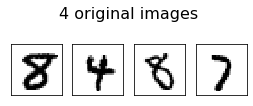

In [ ]:
show_table_images(X_test[:4], "4 original images", 4)

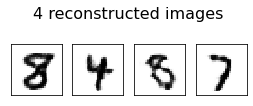

In [ ]:
reconsrtucted = rbm.reconstruct(X_test[:4])
show_table_images(reconsrtucted, "4 reconstructed images", 4)

## Sklearn Classifier over RBM output

Transform the dataset passing throught the RBM and taking the rapresentation in the hidden layer.

In [ ]:
X_train_rbm = rbm.inference(X_train)
X_test_rbm = rbm.inference(X_test)

In [ ]:
print(f"Dimension of the training dataset preprocessed with the RBM: {X_train_rbm.shape}")
print(f"Dimension of the testing dataset preprocessed with the RBM: {X_test_rbm.shape}")

Dimension of the training dataset preprocessed with the RBM: (60000, 144)
Dimension of the testing dataset preprocessed with the RBM: (10000, 144)


In [ ]:
linear_classifier = LogisticRegression(max_iter=500)
linear_classifier.fit(X_train_rbm, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression(max_iter=500)

In [ ]:
y_train_pred = linear_classifier.predict(X_train_rbm)
y_test_pred = linear_classifier.predict(X_test_rbm)

In [ ]:
print(f"Accuracy over training set {metrics.accuracy_score(y_train, y_train_pred, normalize=True)}")
print(f"Accuracy over test set  {metrics.accuracy_score(y_test, y_test_pred, normalize=True)}")

Accuracy over training set 0.9397666666666666
Accuracy over test set  0.9339


## Conclusions
We can conclude that the RBM model can reconstruct well the test images as we have seen in the notebook. Moreover when we preprocess the dataset taking the hidden probabilities, instead of the original images, the training is faster, due to the lighter dataset, (using sklearn logistic regressor) and the accuracy doesn't drop too much or even remain the same.

The implementation of the RBM presented in this notebook is based on the CD-1 learning method as the trace tell, this kind of learning, as I sayd in the comments, is a crude approximation of the log-likelihood gradient ascent, if instead we use the CD-k, doing the gibbs sampling for k time before compute the dream part of CD, we could have less reconstruction error and better results for the logistic regression constructed over the hidden representation. Moreover the same considerations can be done for the number of hidden neurons more hidden units better capacity to learn complex structure of the data, but this impose more complex over the training phase.